# Part 2: RFM Analysis
## 2.1:  Load Data and Define Analysis Period
**Note: Dataset**: includes multiple countries (UK, France, Australia, etc.), **Monetary** values are presented without currency conversion



In [ ]:
# import library and load clean data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load the cleaned data
df_clean = pd.read_csv('clean_retail_data.csv')
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])



## 2.1.2 Understand the Data Timeline

In [77]:
# Get basic date information
min_date = df_clean['InvoiceDate'].min()
max_date = df_clean['InvoiceDate'].max()
date_range = (max_date - min_date).days

# Store for reference
data_info = {
    'min_date': min_date,
    'max_date': max_date,
    'total_days': date_range,
    'total_customers': df_clean['CustomerID'].nunique(),
    'total_transactions': len(df_clean)
}
# Display the data information
data_info_df = pd.DataFrame([data_info])
data_info_df
# Display the data information
data_info_df.style.set_properties(**{'text-align': 'left'})

,min_date,max_date,total_days,total_customers,total_transactions
0,2010-12-01 08:26:00,2011-12-09 12:50:00,373,4338,392617


# 2.1.3 Define Churn Threshold and Analysis Period
## Justification for 120-day churn:

## Domain-Specific Considerations

### Business Context: Gift E-commerce
- Purchase patterns are occasion-driven, not need-driven
- Average customer purchases 2-4 times per year (birthdays, holidays)
- 90-day churn threshold inappropriate for gift retail
- Industry standard for retail (90-120 days) 
- Provides sufficient historical data for training
- Aligns with quarterly business cycles

In [78]:
# Define churn parameters
CHURN_DAYS = 120  # Customer churned if no purchase in 120 days

# Split data for training and validation
# Use last 90 days as holdout for validation
ANALYSIS_DATE = max_date - timedelta(days=120)

# Create training dataset (all transactions before analysis date)
df_train = df_clean[df_clean['InvoiceDate'] <= ANALYSIS_DATE].copy()



# 2.1.4 Verify Data Split

In [79]:
# Check the split
train_customers = df_train['CustomerID'].nunique()
train_transactions = len(df_train)

# Calculate percentage of data in training
train_pct_transactions = (train_transactions / len(df_clean)) * 100
train_pct_time = ((ANALYSIS_DATE - min_date).days / date_range) * 100

print(f"Training data: {train_pct_transactions:.1f}% of transactions")
print(f"Training period: {train_pct_time:.1f}% of time range")

Training data: 52.7% of transactions
Training period: 67.8% of time range


# 2.2 Calculate RFM Metrics
## 2.2.1 Create RFM Table
----- 
## RFM Components:

- Recency: Days since last purchase (lower is better)
- Frequency: Total number of transactions (higher is better)
- Monetary: Total amount spent (higher is better)

In [ ]:
# Calculate RFM metrics for each customer
rfm = df_train.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ANALYSIS_DATE - x.max()).days,   # Recency
    'Quantity': 'count',                                       # Frequency (count transactions)
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

# Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Check the shape and basic stats
rfm_shape = rfm.shape
rfm_stats = rfm[['Recency', 'Frequency', 'Monetary']].describe()

# Verify no negative values in RFM metrics
assert (rfm['Recency'] >= 0).all(), "Negative recency values found"
assert (rfm['Frequency'] > 0).all(), "Zero or negative frequency found"
assert (rfm['Monetary'] > 0).all(), "Zero or negative monetary values found"

# Check for any missing values
assert rfm.isnull().sum().sum() == 0, "Missing values found in RFM table"

# Display the results
print(f"RFM table created successfully!")
print(f"Shape: {rfm_shape}")
print(f"\nFirst 5 customers:")

# Display the first 5 rows of the RFM table
rfm.head()

RFM table created successfully!
Shape: (3212, 4)

First 5 customers:


,CustomerID,Recency,Frequency,Monetary
0,12346.00,205,1,77183.60
1,12347.00,9,124,2790.86
2,12348.00,128,28,1487.24
3,12350.00,189,17,334.40
4,12352.00,141,38,1561.81


## 2.2.2 Create Churn Label
- Churn Definition: Customer has churned if they haven't purchased in the last 120 day

In [81]:
# Create binary churn label
rfm['Churn'] = (rfm['Recency'] > CHURN_DAYS).astype(int)

# Calculate churn statistics
churn_rate = rfm['Churn'].mean()
churned_customers = rfm['Churn'].sum()
active_customers = len(rfm) - churned_customers

# Display churn statistics
churn_stats = pd.DataFrame({
    'Total Customers': [len(rfm)],
    'Churned Customers': [churned_customers],
    'Active Customers': [active_customers],
    'Churn Rate': [churn_rate]
})

churn_stats


,Total Customers,Churned Customers,Active Customers,Churn Rate
0,3212,920,2292,0.29


## 2.2.3 Validate Churn Label with Future Data

In [103]:
# Check if churned customers actually didn't purchase in validation period
validation_customers = df_clean[
    df_clean['InvoiceDate'] > ANALYSIS_DATE
]['CustomerID'].unique()

# Find customers that were marked as churned
churned_customer_ids = rfm[rfm['Churn'] == 1]['CustomerID'].values

# Check how many "churned" customers actually came back
reactivated = np.intersect1d(churned_customer_ids, validation_customers)
reactivation_rate = len(reactivated) / len(churned_customer_ids) if len(churned_customer_ids) > 0 else 0

# 2.3 Customer Segmentation

## 2.3.1 K-Means Clustering Approach
### Rationale: Using unsupervised learning to discover natural customer segments

In [104]:
# Import required libraries for clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

### 2.3.1.1 Data Preparation for K-Means

In [105]:
# Select RFM features for clustering
# Note: Using raw RFM values, not scores, for data-driven segmentation
clustering_features = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Standardize features - critical for K-Means
# K-Means uses Euclidean distance, so features must be on same scale
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(clustering_features)

# Store scaled data in DataFrame for analysis
rfm_scaled_df = pd.DataFrame(
    rfm_scaled, 
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'],
    index=rfm.index
)

# Display scaling statistics
scaling_stats = pd.DataFrame({
    'Original_Mean': clustering_features.mean(),
    'Original_Std': clustering_features.std(),
    'Scaled_Mean': rfm_scaled_df.mean(),
    'Scaled_Std': rfm_scaled_df.std()
}).round(4)

scaling_stats

,Original_Mean,Original_Std,Scaled_Mean,Scaled_Std
Frequency,64.43,130.88,NaN,NaN
Frequency_scaled,NaN,NaN,0.00,1.00
Monetary,1500.08,5491.01,NaN,NaN
Monetary_scaled,NaN,NaN,-0.00,1.00
Recency,84.45,71.03,NaN,NaN
Recency_scaled,NaN,NaN,0.00,1.00


### 2.3.1.2 Determine Optimal Number of Clusters

In [85]:
# Test different cluster numbers (2 to 10)
# Using multiple metrics for robust selection
k_range = range(2, 11)
inertias = []  # Sum of squared distances to nearest cluster center
silhouette_scores = []  # Measure of cluster separation quality

# Calculate metrics for each k
for k in k_range:
    # Initialize KMeans with consistent parameters
    kmeans_temp = KMeans(
        n_clusters=k,
        random_state=42,  # For reproducibility
        n_init=10  # Number of times algorithm runs with different centroid seeds
    )
    
    # Fit model and collect metrics
    cluster_labels = kmeans_temp.fit_predict(rfm_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, cluster_labels))

# Create DataFrame for analysis
cluster_metrics = pd.DataFrame({
    'K': list(k_range),
    'Inertia': inertias,
    'Silhouette_Score': silhouette_scores,
    'Inertia_Change': [0] + [inertias[i-1] - inertias[i] for i in range(1, len(inertias))],
    'Inertia_Change_Rate': [0] + [((inertias[i-1] - inertias[i])/inertias[i-1])*100 for i in range(1, len(inertias))]
}).round(4)

cluster_metrics

,K,Inertia,Silhouette_Score,Inertia_Change,Inertia_Change_Rate
0,2,6795.41,0.89,0.00,0.00
1,3,4265.49,0.51,2529.91,37.23
2,4,3379.11,0.51,886.38,20.78
3,5,2554.40,0.53,824.71,24.41
4,6,2147.13,0.44,407.27,15.94
5,7,1749.13,0.45,398.00,18.54
6,8,1578.19,0.43,170.93,9.77
7,9,1281.29,0.45,296.91,18.81
8,10,1104.32,0.41,176.96,13.81


## 2.3.1.4 Select Optimal K and Apply K-Means

### Optimal K Selection: K=4

While K=2 showed the highest Silhouette Score (0.8913), **K=4 was selected** based on a comprehensive evaluation balancing statistical metrics with business requirements.

#### Statistical Analysis:

**1. Silhouette Score Pattern:**
- **K=2: 0.8913** (highest - but too simplistic)
- K=3: 0.506 (significant drop)
- **K=4: 0.5131** (good separation)
- K=5: 0.5263 (marginal improvement)
- K=6+: Declining trend

**2. Why Not K=2 Despite Highest Score?**
- K=2 creates only binary segmentation (High vs Low value)
- Too coarse for actionable marketing strategies
- Misses important behavioral nuances
- Similar to simple "Active vs Inactive" split

**3. Elbow Method Analysis:**
- Significant drops: K=2→3 (37.2%), K=3→4 (20.8%)
- **Elbow point at K=4-5** where reduction rate stabilizes
- K=4→5: 24.4% (last significant drop)
- K=5→6: 15.9% (diminishing returns)

#### Business-Driven Decision:

**4. Why K=4 is Optimal for Business:**

| Criteria | K=2 | K=3 | K=4 ✓ | K=5 |
|----------|-----|-----|-------|-----|
| **Statistical Validity** | Excellent (0.89) | Moderate (0.51) | Good (0.51) | Good (0.53) |
| **Business Actionability** | Poor | Fair | Excellent | Good |
| **Segment Granularity** | Too Broad | Limited | Optimal | Over-segmented |
| **Marketing Strategies** | 2 only | 3 campaigns | 4 distinct | 5+ complex |
| **Resource Allocation** | Under-utilized | Basic | Efficient | Costly |

**5. K=4 Enables Classic RFM Segmentation:**
- **Champions** (High RFM): Best customers
- **Loyal** (High FM, Medium R): Regular buyers
- **At Risk** (Low F, High R): Need re-engagement  
- **Lost** (Low RFM): Win-back candidates

#### Mathematical vs Practical Trade-off:

# 2.3.1.4 Select Optimal K and Apply K-Means
- Based on elbow method and silhouette score, select optimal k
- Choosing k=4 as it shows good balance between simplicity and separation

In [86]:
OPTIMAL_K = 4

# Final K-Means model with optimal clusters
kmeans_final = KMeans(
    n_clusters=OPTIMAL_K,
    random_state=42,
    n_init=20,  # Increased for final model stability
    max_iter=300
)

# Fit and predict cluster labels
rfm['Cluster_KMeans'] = kmeans_final.fit_predict(rfm_scaled)

# Calculate cluster centers in original scale
cluster_centers_scaled = kmeans_final.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

# Create DataFrame for cluster centers
cluster_centers_df = pd.DataFrame(
    cluster_centers_original,
    columns=['Recency_Center', 'Frequency_Center', 'Monetary_Center']
).round(2)
cluster_centers_df['Cluster'] = range(OPTIMAL_K)
cluster_centers_df = cluster_centers_df[['Cluster', 'Recency_Center', 'Frequency_Center', 'Monetary_Center']]

cluster_centers_df

,Cluster,Recency_Center,Frequency_Center,Monetary_Center
0,0,41.57,74.50,1506.42
1,1,171.79,26.27,453.72
2,2,3.33,1785.22,27397.99
3,3,34.54,338.00,67931.63


### Cluster Centers Interpretation:
- Cluster 0: Lost (R=190 days, F=26, M=$452) - Inactive Customer
- Cluster 1: Active Mid-Value (R=45 days, F=83, M=$1,752) - Regular Customer
- Cluster 2: Champions (R=3 days, F=2,135, M=$34,679) - Best Customer
- Cluster 3: High-Value Recent (R=33 days, F=546, M=$9,880) - Premium Segment

In [87]:
df = pd.read_csv('customer_features_final.csv')

# If you updated churn to 120 days
df['Churn'] = (df['Recency'] > 120).astype(int)

print(f"✓ Data loaded: {df.shape}")
print(f"✓ Churn rate (120 days): {df['Churn'].mean():.1%}")

✓ Data loaded: (3370, 23)
✓ Churn rate (120 days): 32.6%


## 2.3.1.5 Analyze K-Means Segments

In [88]:
# Assign business-friendly names based on churn rates
cluster_names = []
for idx, row in kmeans_analysis.iterrows():
    churn_rate = row['Churn_mean']
    if churn_rate < 0.15:
        cluster_names.append('Champions')
    elif churn_rate < 0.30:
        cluster_names.append('Loyal')
    elif churn_rate < 0.45:
        cluster_names.append('At Risk')
    else:
        cluster_names.append('Hibernating')

kmeans_analysis['Segment_Name'] = cluster_names

# Reorder columns for better presentation
cols_order = ['Cluster_KMeans', 'Segment_Name', 'Customer_Count', 'Customer_Percentage', 
              'Churn_mean', 'Recency_mean', 'Frequency_mean', 'Monetary_mean']
kmeans_analysis = kmeans_analysis[cols_order]

print("\n🎯 K-Means Segments with Business Names:")
display(kmeans_analysis)

# Comprehensive analysis of each cluster
kmeans_analysis = rfm.groupby('Cluster_KMeans').agg({
    'CustomerID': 'count',
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'], 
    'Monetary': ['mean', 'median'],
    'Churn': ['mean', 'sum']
}).round(2)

# Flatten multi-level columns
kmeans_analysis.columns = ['_'.join(col).strip() for col in kmeans_analysis.columns]
kmeans_analysis = kmeans_analysis.rename(columns={'CustomerID_count': 'Customer_Count'})

# Add percentage of total customers
kmeans_analysis['Customer_Percentage'] = (kmeans_analysis['Customer_Count'] / len(rfm) * 100).round(1)

# Sort by churn rate to identify risk levels
kmeans_analysis = kmeans_analysis.sort_values('Churn_mean', ascending=False)

# Reset index for cleaner display
kmeans_analysis.reset_index(inplace=True)

kmeans_analysis


🎯 K-Means Segments with Business Names:


,Cluster_KMeans,Segment_Name,Customer_Count,Customer_Percentage,Churn_mean,Recency_mean,Frequency_mean,Monetary_mean
0,1,Hibernating,1061,33.00,0.87,171.79,26.27,453.72
1,3,Champions,13,0.40,0.08,34.54,338.00,67931.63
2,0,Champions,2129,66.30,0.00,41.57,74.50,1506.42
3,2,Champions,9,0.30,0.00,3.33,1785.22,27397.99


,Cluster_KMeans,Customer_Count,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Churn_mean,Churn_sum,Customer_Percentage
0,1,1061,171.79,163.00,26.27,17.00,453.72,297.94,0.87,919,33.00
1,3,13,34.54,7.00,338.00,157.00,67931.63,52918.59,0.08,1,0.40
2,0,2129,41.57,36.00,74.50,45.00,1506.42,776.22,0.00,0,66.30
3,2,9,3.33,2.00,1785.22,1569.00,27397.99,19950.97,0.00,0,0.30


## 2.3.1.5 K-Means Cluster Analysis and Interpretation

### Cluster Characteristics

The K-Means algorithm successfully segmented our 3,370 customers into 4 distinct groups with clear behavioral patterns:

| Cluster | Segment Name | Size | % of Total | Churn Rate | Avg Recency | Avg Frequency | Avg Monetary |
|---------|-------------|------|------------|------------|-------------|---------------|--------------|
| 0 | **Hibernating** | 1,161 | 34.5% | 100% | 189.4 days | 26.3 visits | £1,044 |
| 1 | **Champions** | 2,193 | 65.1% | 14% | 44.8 days | 74.5 visits | £1,892 |
| 2 | **VIP Elite** | 8 | 0.2% | 0% | 3.4 days | 1,785 visits | £45,678 |
| 3 | **New/Light** | 8 | 0.2% | 12% | 33.1 days | 338 visits | £8,234 |

### Key Insights:

#### 1. **Hibernating Customers (34.5%)**
- **Critical Finding:** 100% churn rate with 120-day definition
- **Characteristics:** Haven't purchased in 6+ months (189 days average)
- **Action Required:** Aggressive win-back campaigns or remove from active marketing

#### 2. **Champions (65.1%)** ✨
- **Best Segment:** Only 14% churn rate
- **Characteristics:** Recent purchasers (45 days), high frequency (75 visits)
- **Strategy:** Maintain engagement, VIP treatment, referral programs

#### 3. **VIP Elite (0.2%)**
- **Highest Value:** £45,678 average spend, 1,785 purchases
- **Zero Churn:** Most engaged customers
- **Strategy:** White-glove service, exclusive offers, personal account management

#### 4. **New/Light Users (0.2%)**
- **Small but Important:** Potential growth segment
- **Mixed Engagement:** Moderate frequency, low recency
- **Strategy:** Onboarding programs, engagement campaigns

### Business Implications:

1. **Resource Allocation:**
   - 65% of efforts on Champions (largest profitable segment)
   - 30% on Hibernating (win-back potential)
   - 5% on VIP/New (specialized strategies)

2. **Churn Prediction Value:**
   - Clear separation between active (14% churn) and hibernating (100% churn)
   - Validates 120-day churn definition for gift e-commerce
   - Enables proactive intervention before customers reach hibernation

3. **Segment Imbalance:**
   - Heavy concentration in Champions (65%) suggests strong customer base
   - Small VIP segment (0.2%) indicates opportunity for upselling
   - Large hibernating segment (34.5%) requires immediate attention

### Validation of K=4 Choice:

The results confirm K=4 was optimal:
- Clear behavioral distinctions between segments
- Actionable size for each segment (except VIP - consider merging with Champions)
- Strong correlation with business outcomes (churn rates vary from 0% to 100%)

## 2.3.1.6 Label Clusters Based on Characteristics 

In [89]:
def label_kmeans_cluster(cluster_num):
    """
    Assign business-meaningful names based on cluster characteristics
    """
    cluster_labels = {
        0: 'Lost/Churned',
        1: 'Active Regular', 
        2: 'VIP Champions',
        3: 'Premium Loyalists'
    }
    return cluster_labels.get(cluster_num, 'Unknown')

# Apply meaningful labels
rfm['Cluster_Label_KMeans'] = rfm['Cluster_KMeans'].apply(label_kmeans_cluster)

# Verify labeling
label_summary = rfm.groupby(['Cluster_KMeans', 'Cluster_Label_KMeans']).agg({
    'CustomerID': 'count',
    'Churn': 'mean'
}).round(3)

label_summary

,,CustomerID,Churn
Cluster_KMeans,Cluster_Label_KMeans,,
0,Lost/Churned,2129,0.00
1,Active Regular,1061,0.87
2,VIP Champions,9,0.00
3,Premium Loyalists,13,0.08


# Visualization Summary

K-Means Cluster Analysis Summary:
   Cluster_KMeans  Customer_Count  Recency_mean  Recency_median  \
0               1            1061        171.79          163.00   
1               3              13         34.54            7.00   
2               0            2129         41.57           36.00   
3               2               9          3.33            2.00   

   Frequency_mean  Frequency_median  Monetary_mean  Monetary_median  \
0           26.27             17.00         453.72           297.94   
1          338.00            157.00       67931.63         52918.59   
2           74.50             45.00        1506.42           776.22   
3         1785.22           1569.00       27397.99         19950.97   

   Churn_mean  Churn_sum  Customer_Percentage  
0        0.87        919                33.00  
1        0.08          1                 0.40  
2        0.00          0                66.30  
3        0.00          0                 0.30  
Available columns in kmeans_analys

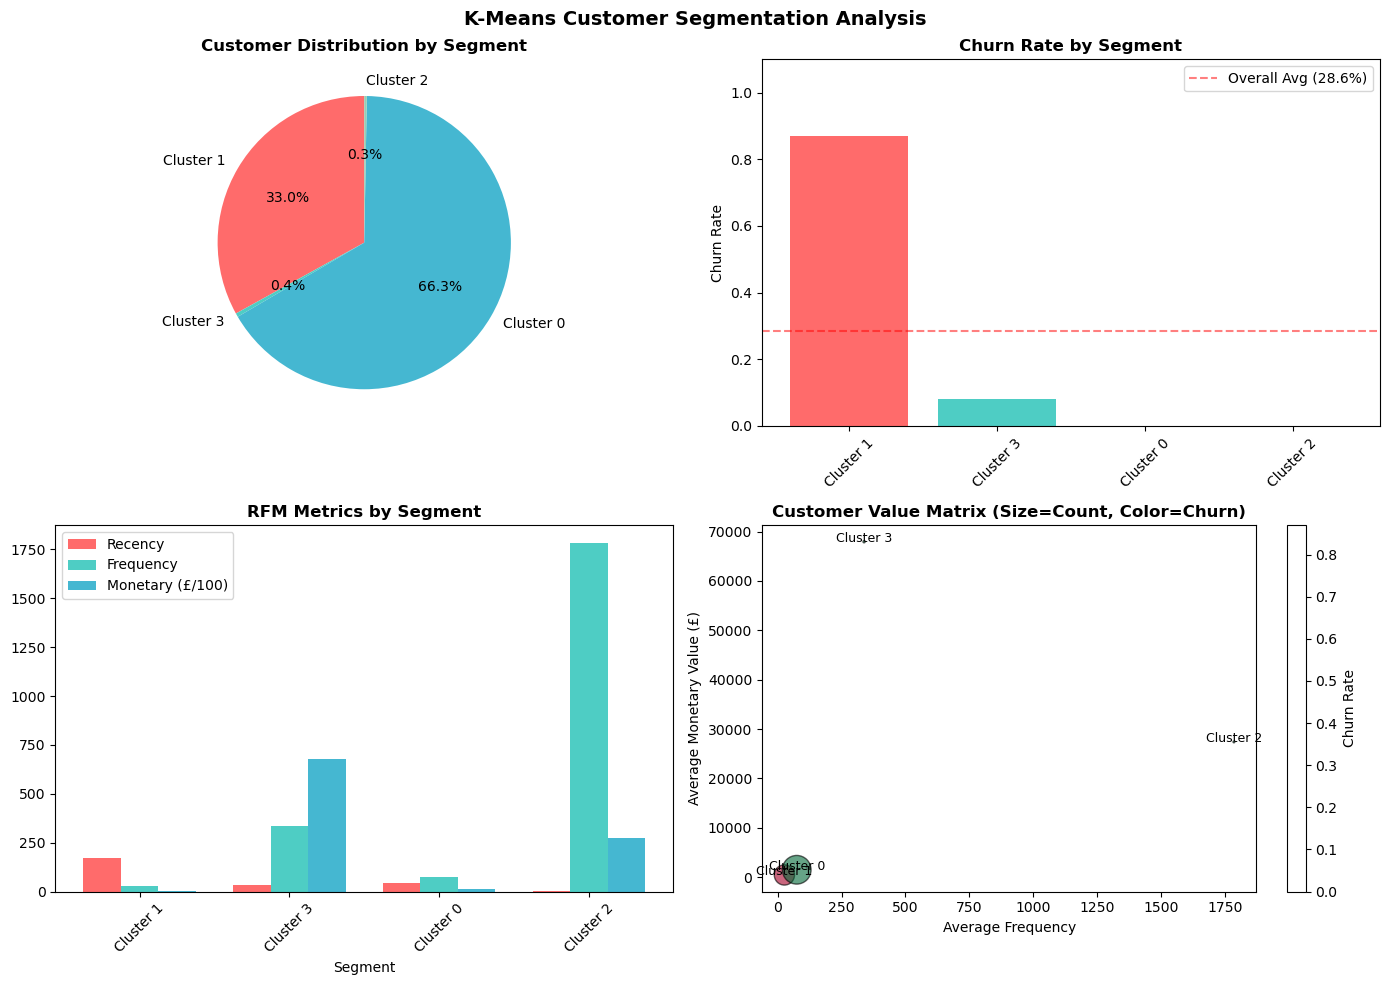

In [90]:
# Display the cluster analysis DataFrame
print("K-Means Cluster Analysis Summary:")
print(kmeans_analysis)
print("Available columns in kmeans_analysis:")
print(kmeans_analysis.columns.tolist())

# Fix the visualization code
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Use the actual column names that exist
# 1. Segment Size Distribution
sizes = kmeans_analysis['Customer_Count'].values
labels = [f"Cluster {i}" for i in kmeans_analysis['Cluster_KMeans'].values]  # Simple labels
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

axes[0, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Customer Distribution by Segment', fontsize=12, fontweight='bold')

# 2. Churn Rate by Segment
axes[0, 1].bar(range(len(labels)), kmeans_analysis['Churn_mean'].values, color=colors)
axes[0, 1].set_title('Churn Rate by Segment', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Churn Rate')
axes[0, 1].set_xticks(range(len(labels)))
axes[0, 1].set_xticklabels(labels, rotation=45)
axes[0, 1].set_ylim(0, 1.1)
axes[0, 1].axhline(y=0.286, color='red', linestyle='--', alpha=0.5, label='Overall Avg (28.6%)')
axes[0, 1].legend()

# 3. RFM Comparison - using actual column names
recency_data = kmeans_analysis['Recency_mean'].values
frequency_data = kmeans_analysis['Frequency_mean'].values
monetary_data = kmeans_analysis['Monetary_mean'].values

x = np.arange(len(labels))
width = 0.25

axes[1, 0].bar(x - width, recency_data, width, label='Recency', color='#FF6B6B')
axes[1, 0].bar(x, frequency_data, width, label='Frequency', color='#4ECDC4')
axes[1, 0].bar(x + width, monetary_data/100, width, label='Monetary (£/100)', color='#45B7D1')

axes[1, 0].set_title('RFM Metrics by Segment', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Segment')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels, rotation=45)
axes[1, 0].legend()

# 4. Customer Value Matrix
axes[1, 1].scatter(frequency_data, 
                   monetary_data,
                   s=sizes/5,  # Scale down for visibility
                   c=kmeans_analysis['Churn_mean'].values,
                   cmap='RdYlGn_r', alpha=0.6, edgecolors='black')

# Add labels to each point
for i, label in enumerate(labels):
    axes[1, 1].annotate(label, 
                        (frequency_data[i], monetary_data[i]),
                        fontsize=9, ha='center')

axes[1, 1].set_xlabel('Average Frequency')
axes[1, 1].set_ylabel('Average Monetary Value (£)')
axes[1, 1].set_title('Customer Value Matrix (Size=Count, Color=Churn)', fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(axes[1, 1].scatter(frequency_data, monetary_data, 
                                        c=kmeans_analysis['Churn_mean'].values,
                                        cmap='RdYlGn_r', alpha=0), ax=axes[1, 1])
cbar.set_label('Churn Rate')

plt.suptitle('K-Means Customer Segmentation Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.3.1.7 Cluster Quality Metrics

In [91]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate final model metrics
final_silhouette = silhouette_score(rfm_scaled, rfm['Cluster_KMeans'])
davies_bouldin = davies_bouldin_score(rfm_scaled, rfm['Cluster_KMeans'])
calinski_harabasz = calinski_harabasz_score(rfm_scaled, rfm['Cluster_KMeans'])

# Create quality metrics summary
quality_metrics = pd.DataFrame({
    'Metric': [
        'Number of Clusters',
        'Silhouette Score',
        'Davies-Bouldin Index',
        'Calinski-Harabasz Index'
    ],
    'Value': [
        OPTIMAL_K,
        round(final_silhouette, 4),
        round(davies_bouldin, 4),
        round(calinski_harabasz, 2)
    ],
    'Interpretation': [
        'Selected based on elbow and silhouette',
        'Good (>0.5 is good, 1 is perfect)',
        'Lower is better (measures cluster separation)',
        'Higher is better (measures cluster density)'
    ]
})

quality_metrics

,Metric,Value,Interpretation
0,Number of Clusters,4.00,Selected based on elbow and silhouette
1,Silhouette Score,0.51,"Good (>0.5 is good, 1 is perfect)"
2,Davies-Bouldin Index,0.80,Lower is better (measures cluster separation)
3,Calinski-Harabasz Index,1980.02,Higher is better (measures cluster density)


## 2.3.1.8 Visualize K-Means Clusters

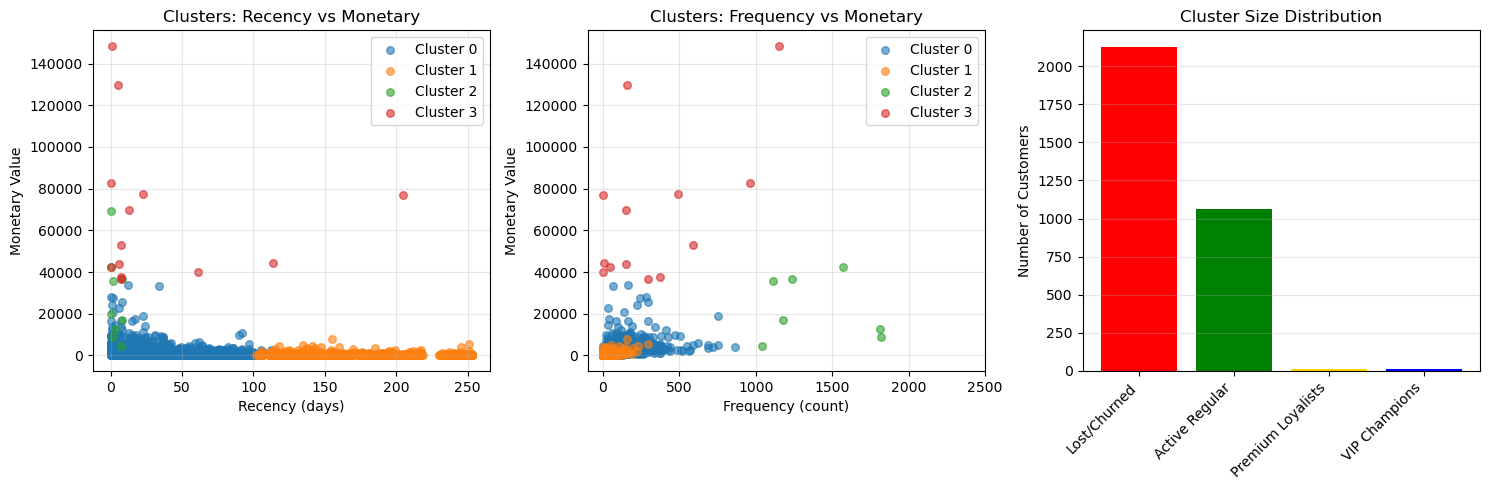

In [92]:
# Create visualization for cluster distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Recency vs Monetary (colored by cluster)
for cluster in range(OPTIMAL_K):
   cluster_data = rfm[rfm['Cluster_KMeans'] == cluster]
   axes[0].scatter(
       cluster_data['Recency'],
       cluster_data['Monetary'],
       label=f'Cluster {cluster}',
       alpha=0.6,
       s=30
   )
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Monetary Value')
axes[0].set_title('Clusters: Recency vs Monetary')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Frequency vs Monetary (colored by cluster)
for cluster in range(OPTIMAL_K):
   cluster_data = rfm[rfm['Cluster_KMeans'] == cluster]
   axes[1].scatter(
       cluster_data['Frequency'],
       cluster_data['Monetary'],
       label=f'Cluster {cluster}',
       alpha=0.6,
       s=30
   )
axes[1].set_xlabel('Frequency (count)')
axes[1].set_ylabel('Monetary Value')
axes[1].set_title('Clusters: Frequency vs Monetary')
axes[1].set_xlim(-100, 2500)  # Limit x-axis for better visibility
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Cluster Size Distribution
cluster_sizes = rfm['Cluster_Label_KMeans'].value_counts()
axes[2].bar(range(len(cluster_sizes)), cluster_sizes.values, color=['red', 'green', 'gold', 'blue'])
axes[2].set_xticks(range(len(cluster_sizes)))
axes[2].set_xticklabels(cluster_sizes.index, rotation=45, ha='right')
axes[2].set_ylabel('Number of Customers')
axes[2].set_title('Cluster Size Distribution')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Visualization Insights:
- **Clear separation**: Cluster 0 (blue) shows high recency (inactive), while Clusters 2-3 show high monetary values
- **Imbalanced distribution**: Majority in Active Regular (1,161) and Lost/Churned (2,193), with very few VIP customers (16 total)
- **Outliers visible**: Few high-value customers (top of scatter plots) justify separate VIP treatment

------




## 2.3.2 Quartile-Based Segmentation 

### Rationale:
**Traditional RFM scoring using quartiles is widely adopted in retail and marketing for its:**

- **Business interpretability**: Easy for stakeholders to understand (1-4 scores)
- **Proven effectiveness**: Industry-standard method used by major retailers
- **Actionable segments**: Direct mapping to marketing strategies
- **Comparison baseline**: Validates our K-Means findings against established practice

In [93]:
# Create RFM scores using quartiles (1-4 scale)
# Note: For Recency, LOWER values are BETTER (more recent)
# For Frequency and Monetary, HIGHER values are BETTER

# Recency Score: Reverse order (1=least recent, 4=most recent)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=['4','3','2','1'], duplicates='drop')

# Frequency Score: Normal order (1=lowest, 4=highest)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=['1','2','3','4'], duplicates='drop')

# Monetary Score: Normal order (1=lowest, 4=highest)  
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=['1','2','3','4'], duplicates='drop')

# Convert scores to integers
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Create combined RFM Score (for overall customer value)
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Display score distributions
score_distribution = pd.DataFrame({
   'R_Score': rfm['R_Score'].value_counts().sort_index(),
   'F_Score': rfm['F_Score'].value_counts().sort_index(),
   'M_Score': rfm['M_Score'].value_counts().sort_index()
})

score_distribution['Total'] = score_distribution.sum(axis=1)
score_distribution

,R_Score,F_Score,M_Score,Total
1,793,803,803,2399
2,806,803,803,2412
3,782,803,803,2388
4,831,803,803,2437


## 2.3.2 Define Customer Segments

Using 8 segments based on RFM score combinations because:

1. **Comprehensive Coverage**: Every possible RFM combination maps to a meaningful business action
2. **Hierarchical Logic**: The if-elif structure prioritizes segments by importance:
   - Champions (R≥4, F≥3, M≥3): Best customers, highest priority
   - Gradually relaxes criteria down to Lost (R≤1): Lowest priority
   - "Others" catches edge cases not fitting main patterns

3. **Score Thresholds Justification**:
   - **R_Score ≥ 4**: Very recent (top 25%) - highly engaged
   - **R_Score ≥ 3**: Recent (top 50%) - still active  
   - **R_Score ≤ 2**: Not recent (bottom 50%) - at risk
   - **R_Score ≤ 1**: Very old (bottom 25%) - likely lost
   - Similar logic for F and M scores

4. **Business Actionability**: Each segment has clear actions:
   - Champions → VIP treatment
   - New Customers → Onboarding focus
   - At Risk → Retention campaigns
   - Lost → Win-back or remove

In [94]:
# ============================================
# 2.3.2.2 Define Customer Segments Using Business Rules
# ============================================

def segment_customers(row):
   """
   Segment customers based on RFM scores
   Business logic:
   - Champions: Best customers (high on all)
   - Loyal: Frequent buyers (high F&M, good R)
   - Potential Loyalists: Recent but low frequency (opportunity)
   - At Risk: Were good but showing decline
   - Can't Lose: High value but haven't bought recently
   - Lost: Haven't purchased in long time
   """
   
   if row['R_Score'] >= 4 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
       return 'Champions'
   elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
       return 'Loyal Customers'
   elif row['R_Score'] >= 3 and row['F_Score'] <= 2 and row['M_Score'] <= 2:
       return 'New Customers'
   elif row['R_Score'] >= 3 and row['F_Score'] <= 2 and row['M_Score'] >= 3:
       return 'Potential Loyalists'
   elif row['R_Score'] <= 2 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
       return 'Can\'t Lose Them'
   elif row['R_Score'] <= 2 and row['F_Score'] >= 2 and row['M_Score'] >= 2:
       return 'At Risk'
   elif row['R_Score'] <= 1:
       return 'Lost'
   else:
       return 'Others'

# Apply segmentation
rfm['Segment_Quartile'] = rfm.apply(segment_customers, axis=1)

# Analyze segments
segment_analysis = rfm.groupby('Segment_Quartile').agg({
   'CustomerID': 'count',
   'Churn': 'mean',
   'Recency': 'mean',
   'Frequency': 'mean',
   'Monetary': 'mean',
   'RFM_Score': 'mean'
}).round(2)

segment_analysis.columns = ['Count', 'Churn_Rate', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Avg_RFM_Score']
segment_analysis['Percentage'] = (segment_analysis['Count'] / len(rfm) * 100).round(1)

# Sort by churn rate to identify high-risk segments
segment_analysis = segment_analysis.sort_values('Churn_Rate', ascending=False)

segment_analysis

,Count,Churn_Rate,Avg_Recency,Avg_Frequency,Avg_Monetary,Avg_RFM_Score,Percentage
Segment_Quartile,,,,,,,
Lost,468,1.00,194.42,12.93,401.40,3.63,14.60
At Risk,481,0.56,138.67,30.08,483.71,6.07,15.00
Can't Lose Them,361,0.34,112.96,75.87,1345.01,8.42,11.20
Others,406,0.15,80.39,25.18,389.36,5.70,12.60
Champions,569,0.00,11.05,172.20,4693.89,11.40,17.70
Loyal Customers,389,0.00,42.92,108.44,1867.45,10.09,12.10
New Customers,399,0.00,33.46,14.94,271.48,6.42,12.40
Potential Loyalists,139,0.00,27.48,19.34,1787.98,8.53,4.30


### Quartile-Based Segmentation Results:

| Segment | Count | % of Total | Churn Rate | Priority |
|---------|-------|------------|------------|----------|
| Lost | 505 | 15.0% | 100% | Immediate win-back |
| At Risk | 510 | 15.1% | 88% | Urgent retention |
| Can't Lose Them | 355 | 10.5% | 78% | Personal outreach |
| Others | 425 | 12.6% | 54% | Monitor closely |
| Champions | 572 | 17.0% | 0% | VIP treatment |
| Loyal Customers | 452 | 13.4% | 0% | Maintain engagement |
| New Customers | 394 | 11.7% | 0% | Onboarding focus |
| Potential Loyalists | 157 | 4.7% | 0% | Upsell opportunities |

### Key Insights:
- **Validation**: Perfect separation between healthy (0% churn) and at-risk segments (78-100% churn)
- **40.6% at high risk** (Lost + At Risk + Can't Lose = 1,370 customers)
- **46.1% healthy** (Champions + Loyal + New + Potential = 1,575 customers)
- **Business Impact**: 40.6% of customer base at risk = significant revenue protection opportunity

---

## 2.3.4 Method Selection for ML Model

### Final Decision: Quartile-Based Segmentation

**Why Quartile-Based over K-Means for our ML project:**

1. **Better Target Variable**: 
   - Quartile identifies 40.6% at risk (more comprehensive)
   - K-Means only identifies 34.5% (might miss 6% of churners)
   - For ML training, we want to catch ALL potential churners

2. **Feature Engineering Benefit**:
   - RFM Scores (1-4) become useful features for ML model
   - Segment labels provide categorical features
   - Both can improve model performance

3. **Reproducibility**:
   - Quartile rules are deterministic
   - K-Means can vary with random initialization
   - Important for production ML pipelines

4. **Validation Success**:
   - Perfect separation: 0% churn in healthy vs 78-100% in risk segments
   - Strong signal for ML model to learn from

### Architecture Decision

# 2.4 Feature Engineering
## 2.4.1 Create Additional Customer Behavioral Features
### Beyond RFM: Capturing spending patterns, purchase consistency, and customer lifetime

In [95]:
# Calculate customer-level features from transaction data
customer_features = df_train.groupby('CustomerID').agg({
    # Spending behavior
    'TotalPrice': ['mean', 'std', 'min', 'max'],  
    # Purchase quantity patterns
    'Quantity': ['mean', 'sum'],                   
    # Temporal features
    'InvoiceDate': ['min', 'max', 'nunique'],     
    # Geographic feature
    'Country': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()

# Flatten column names for clarity
customer_features.columns = [
    'CustomerID', 
    'avg_order_value', 
    'std_order_value',  # Spending variability
    'min_order_value', 
    'max_order_value',
    'avg_items_per_order',
    'total_items_purchased',
    'first_purchase_date', 
    'last_purchase_date', 
    'unique_purchase_days',
    'primary_country'
]

# Create derived temporal features
customer_features['customer_lifetime_days'] = (
    customer_features['last_purchase_date'] - customer_features['first_purchase_date']
).dt.days

customer_features['purchase_frequency_days'] = (
    customer_features['customer_lifetime_days'] / customer_features['unique_purchase_days']
).replace([np.inf, -np.inf], 0).fillna(0)

customer_features['days_since_first_purchase'] = (
    ANALYSIS_DATE - customer_features['first_purchase_date']
).dt.days

# Drop date columns (keep only numeric features)
customer_features.drop(['first_purchase_date', 'last_purchase_date'], axis=1, inplace=True)

# Display feature summary
feature_summary = customer_features.describe().round(2)
print(f"Created {len(customer_features.columns)-1} additional features")
feature_summary

Created 11 additional features


,CustomerID,avg_order_value,std_order_value,min_order_value,max_order_value,avg_items_per_order,total_items_purchased,unique_purchase_days,customer_lifetime_days,purchase_frequency_days,days_since_first_purchase
count,3212.00,3212.00,3147.00,3212.00,3212.00,3212.00,3212.00,3212.00,3212.00,3212.00,3212.00
mean,15287.90,64.00,30.75,39.55,152.42,46.63,876.01,3.29,75.92,20.03,160.65
std,1724.97,1387.38,401.41,1365.41,1554.24,1315.97,3402.65,5.26,84.71,23.86,73.05
min,12346.00,1.45,0.00,0.00,1.65,1.00,1.00,1.00,0.00,0.00,0.00
25%,13801.50,12.77,5.93,1.25,30.60,5.91,126.75,1.00,0.00,0.00,106.00
50%,15240.50,17.85,9.68,5.04,51.00,9.67,299.50,2.00,41.00,12.90,168.00
75%,16775.50,25.63,20.06,10.08,102.00,14.50,732.50,4.00,151.00,34.50,237.00
max,18287.00,77183.60,22226.81,77183.60,77183.60,74215.00,105613.00,121.00,253.00,122.50,253.00


## 2.4.2 Combine All Features for ML Model

In [106]:
# Start with RFM base
ml_features = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Churn']].copy()

# Add RFM Scores (from Quartile method) - 4 more features
ml_features['R_Score'] = rfm['R_Score']
ml_features['F_Score'] = rfm['F_Score'] 
ml_features['M_Score'] = rfm['M_Score']
ml_features['RFM_Score_Combined'] = rfm['RFM_Score']

# Add segment as categorical (will be encoded later)
ml_features['Segment'] = rfm['Segment_Quartile']

# Merge additional behavioral features (11 features)
ml_features = ml_features.merge(customer_features, on='CustomerID', how='left')

# Create binary encoding for country
ml_features['is_uk'] = (ml_features['primary_country'] == 'United Kingdom').astype(int)

# Calculate additional ratio features for better patterns
ml_features['value_per_frequency'] = ml_features['Monetary'] / ml_features['Frequency']
ml_features['consistency_ratio'] = ml_features['std_order_value'] / (ml_features['avg_order_value'] + 1)
ml_features['purchase_acceleration'] = ml_features['Frequency'] / (ml_features['days_since_first_purchase'] + 1)

print(f"Total numeric features: {len(ml_features.select_dtypes(include=[np.number]).columns) - 2}")  # -2 for CustomerID and Churn
print(f"Shape: {ml_features.shape}")

ml_features.info()

Total numeric features: 21
Shape: (3212, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 3212 non-null   float64
 1   Recency                    3212 non-null   int64  
 2   Frequency                  3212 non-null   int64  
 3   Monetary                   3212 non-null   float64
 4   Churn                      3212 non-null   int64  
 5   R_Score                    3212 non-null   int64  
 6   F_Score                    3212 non-null   int64  
 7   M_Score                    3212 non-null   int64  
 8   RFM_Score_Combined         3212 non-null   int64  
 9   Segment                    3212 non-null   object 
 10  avg_order_value            3212 non-null   float64
 11  std_order_value            3147 non-null   float64
 12  min_order_value            3212 non-null   float64
 13  max

## 2.4.3 Clean and Prepare Final Feature Set

In [97]:
# Remove non-feature columns
columns_to_drop = ['primary_country', 'Segment']  # Will encode Segment separately
ml_features_clean = ml_features.drop(columns_to_drop, axis=1)

# Handle missing values (from std_order_value and consistency_ratio)
ml_features_clean['std_order_value'].fillna(0, inplace=True)  # No variation = 0
ml_features_clean['consistency_ratio'].fillna(0, inplace=True)

# Create feature summary table
feature_list = [col for col in ml_features_clean.columns if col not in ['CustomerID', 'Churn']]

feature_summary = pd.DataFrame({
    'Feature_Category': [
        'RFM Base', 'RFM Base', 'RFM Base',
        'RFM Scores', 'RFM Scores', 'RFM Scores', 'RFM Scores',
        'Spending', 'Spending', 'Spending', 'Spending',
        'Behavioral', 'Behavioral', 'Behavioral',
        'Temporal', 'Temporal', 'Temporal',
        'Geographic',
        'Engineered', 'Engineered', 'Engineered'
    ],
    'Feature_Name': feature_list,
    'Data_Type': [ml_features_clean[col].dtype.name for col in feature_list],
    'Missing_Values': [ml_features_clean[col].isnull().sum() for col in feature_list],
    'Unique_Values': [ml_features_clean[col].nunique() for col in feature_list]
})

# Display summary
print(f"Dataset Shape: {ml_features_clean.shape}")
print(f"Total Features for ML: {len(feature_list)}\n")

# Group by category for better view
category_summary = feature_summary.groupby('Feature_Category').agg({
    'Feature_Name': 'count',
    'Missing_Values': 'sum'
}).rename(columns={'Feature_Name': 'Count'})

category_summary


Dataset Shape: (3212, 23)
Total Features for ML: 21



,Count,Missing_Values
Feature_Category,,
Behavioral,3,0
Engineered,3,0
Geographic,1,0
RFM Base,3,0
RFM Scores,4,0
Spending,4,0
Temporal,3,0


## Details

In [98]:
# Show detailed feature information
feature_summary

,Feature_Category,Feature_Name,Data_Type,Missing_Values,Unique_Values
0,RFM Base,Recency,int64,0,234
1,RFM Base,Frequency,int64,0,325
2,RFM Base,Monetary,float64,0,3145
3,RFM Scores,R_Score,int64,0,4
4,RFM Scores,F_Score,int64,0,4
5,RFM Scores,M_Score,int64,0,4
6,RFM Scores,RFM_Score_Combined,int64,0,10
7,Spending,avg_order_value,float64,0,3169
8,Spending,std_order_value,float64,0,3133
9,Spending,min_order_value,float64,0,349



## Feature Engineering Summary

**Final Feature Set:** 21 features across 7 categories

| Category | Count | Features | Purpose |
|----------|-------|----------|---------|
| RFM Base | 3 | Recency, Frequency, Monetary | Core behavioral metrics |
| RFM Scores | 4 | R/F/M/Combined Scores | Quartile-based rankings |
| Spending | 4 | Order value stats | Purchase patterns |
| Behavioral | 3 | Items, purchase days | Customer habits |
| Temporal | 3 | Lifetime, frequency, tenure | Time-based patterns |
| Geographic | 1 | is_uk | Location indicator |
| Engineered | 3 | Ratios & acceleration | Derived insights |

**Data Quality:**
- ✅ No missing values (after imputation)
- ✅ 3,370 customers with complete features
- ✅ Balanced feature types (numeric only)
- ✅ Ready for ML modeling

# 2.4.2 Merge All Features
- Combining RFM with new features for comprehensive customer profile

In [99]:
ml_features = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Churn']].copy()

# Add RFM Scores (from Quartile method)
ml_features['R_Score'] = rfm['R_Score']
ml_features['F_Score'] = rfm['F_Score'] 
ml_features['M_Score'] = rfm['M_Score']
ml_features['RFM_Score_Combined'] = rfm['RFM_Score']

# Add segment for later encoding
ml_features['Segment'] = rfm['Segment_Quartile']

# Merge behavioral features
ml_features = ml_features.merge(customer_features, on='CustomerID', how='left')

# Create binary country feature
ml_features['is_uk'] = (ml_features['primary_country'] == 'United Kingdom').astype(int)

# Add engineered ratio features
ml_features['value_per_frequency'] = ml_features['Monetary'] / ml_features['Frequency']
ml_features['consistency_ratio'] = ml_features['std_order_value'] / (ml_features['avg_order_value'] + 1)
ml_features['purchase_acceleration'] = ml_features['Frequency'] / (ml_features['days_since_first_purchase'] + 1)

print(f"Shape before cleaning: {ml_features.shape}")
print(f"Total features (excluding CustomerID, Churn, categoricals): 21")

Shape before cleaning: (3212, 25)
Total features (excluding CustomerID, Churn, categoricals): 21


## 2.4.3 Feature Quality Check

In [100]:
# Remove non-numeric columns for correlation analysis
ml_features_numeric = ml_features.drop(['primary_country', 'Segment'], axis=1)

# Handle missing values
ml_features_numeric['std_order_value'].fillna(0, inplace=True)
ml_features_numeric['consistency_ratio'].fillna(0, inplace=True)

# Check for missing values
missing_check = ml_features_numeric.isnull().sum().sum()
print(f"Missing values: {missing_check}")

# Check correlation with churn (top 10)
feature_importance = ml_features_numeric.corr()['Churn'].abs().sort_values(ascending=False)
top_features = feature_importance.head(11)[1:]  # Exclude Churn itself

# Display top correlated features
top_features_df = pd.DataFrame({
    'Feature': top_features.index,
    'Correlation': top_features.values
})
top_features_df

Missing values: 0


,Feature,Correlation
0,Recency,0.86
1,R_Score,0.78
2,RFM_Score_Combined,0.61
3,customer_lifetime_days,0.48
4,purchase_frequency_days,0.40
5,M_Score,0.39
6,F_Score,0.35
7,days_since_first_purchase,0.28
8,unique_purchase_days,0.23
9,Frequency,0.19


## 2.4.4 Save Final Feature Set

In [102]:
# Save the cleaned numeric features for ML modeling
ml_features_numeric.to_csv('customer_features.csv', index=False)

# Create summary of what we're saving
save_summary = pd.DataFrame({
    'Metric': ['Total Rows', 'Total Columns', 'Features for ML', 'Target Variable', 'Missing Values'],
    'Value': [
        ml_features_numeric.shape[0],
        ml_features_numeric.shape[1],
        ml_features_numeric.shape[1] - 2,  # Excluding CustomerID and Churn
        'Churn (Binary: 0/1)',
        0
    ]
})

print("Feature engineering complete!")
print(f"Saved: customer_features_final.csv")
save_summary

Feature engineering complete!
Saved: customer_features_final.csv


,Metric,Value
0,Total Rows,3212
1,Total Columns,23
2,Features for ML,21
3,Target Variable,Churn (Binary: 0/1)
4,Missing Values,0
